In [57]:
from pathlib import Path
import random
import json

import yaml
import cv2
import matplotlib.pyplot as plt

from models.sift.infer import SIFTDetector
from models.sift.evaluate import DetectorEvaluator
from models.sift.model_utils import visualize_case, compute_iou

In [2]:
# TODO: Retrieve-Reconstruct Fialures [DONE]
# TODO: Sample and Visualise Results with IoU [DONE]
# TODO: Implement Runs

In [3]:
# -- LOADERS -- #
def load_dataset(config, skip_class_names=None):
    """
    Load COCO
    """
    project_root = Path(config['paths']['project_root'])
    data_root = project_root / config['paths']['data_root']
    
    ann_path = data_root / config['data']['annotations_path']
    with open(ann_path, 'r') as f:
        annotations = json.load(f)
    
    img_root = data_root / config['data']['img_root']
    for img in annotations['images']:
        img['file_name'] = str(img_root / img['file_name'])
    
    if skip_class_names:
        name_to_id = {cat['name']: cat['id'] for cat in annotations['categories']}
        
        skip_class_ids = [name_to_id[name] for name in skip_class_names]
        
        annotations['annotations'] = [
            ann for ann in annotations['annotations']
            if ann['category_id'] not in skip_class_ids
        ]
    
    imgs = annotations['images']
    ann_dict = {}
    for ann in annotations['annotations']:
        img_id = ann['image_id']
        if img_id not in ann_dict:
            ann_dict[img_id] = []
        ann_dict[img_id].append(ann)
    
    return imgs, ann_dict

def load_templates(config):
    """Load Template """
    project_root = Path(config['paths']['project_root'])
    data_root = project_root / config['paths']['data_root']
    
    templates = {
        class_id: cv2.imread(str(data_root / path), cv2.IMREAD_GRAYSCALE)
        for class_id, path in config['model']['template_paths'].items()
    }
        
    return templates

In [5]:
# -- CONFIG -- #
sift_cofig_path = "models/sift/model_config.yaml"
skipped = 'nectar_price_lozenge'

with open(sift_cofig_path, 'r') as f:
    config = yaml.safe_load(f)

imgs, annotations = load_dataset(config, skip_class_names=[skipped])

templates = {
    class_id: cv2.imread(
        str(Path(config['paths']['project_root']) / config['paths']['data_root'] / path), 
        cv2.IMREAD_GRAYSCALE
    )
    for class_id, path in config['model']['template_paths'].items()
}

In [6]:
# -- INTIT MODEL -- #
detector = SIFTDetector(templates)
evaluator = DetectorEvaluator(iou_threshold=config["evaluation"]["iou_threshold"])

In [7]:
metrics, failures = evaluator.evaluate(
    imgs=imgs,
    annotations=annotations,
    detector_fn=detector.detect_objects,
    run_name="sift_detector"
)

2025-02-18 22:22:08,740 - INFO - Starting evaluation run: sift_detector
2025-02-18 22:22:09,239 - INFO - Detected 1 at [16, 1150, 408, 446]
2025-02-18 22:22:09,308 - INFO - Detected 2 at [1040, 1282, 354, 125]
2025-02-18 22:22:09,550 - INFO - Detected 1 at [651, 925, 159, 130]
2025-02-18 22:22:09,587 - INFO - Detected 2 at [848, 948, 212, 75]
2025-02-18 22:22:09,896 - INFO - Detected 1 at [422, 700, 47, 29]
2025-02-18 22:22:09,953 - INFO - Detected 2 at [741, 922, 305, 108]
2025-02-18 22:22:10,173 - INFO - Detected 1 at [654, 925, 160, 132]
2025-02-18 22:22:10,201 - INFO - Detected 2 at [853, 949, 212, 75]
2025-02-18 22:22:10,601 - INFO - Detected 1 at [647, 1767, 160, 132]
2025-02-18 22:22:10,647 - INFO - Detected 2 at [846, 1791, 212, 75]
2025-02-18 22:22:10,961 - INFO - Detected 1 at [696, 1204, 141, 116]
2025-02-18 22:22:11,015 - INFO - Detected 2 at [860, 1226, 195, 69]
2025-02-18 22:22:11,263 - INFO - Detected 1 at [699, 35, 148, 122]
2025-02-18 22:22:11,297 - INFO - Detected 2 a

In [8]:
metrics

{2: {'precision': 0.9835164781125468,
  'recall': 0.9781420711576936,
  'f1': 0.9808214124378605,
  'total_predictions': 182,
  'total_ground_truth': 183},
 1: {'precision': 0.9999999935483872,
  'recall': 0.9810126520189073,
  'f1': 0.9904148291809117,
  'total_predictions': 155,
  'total_ground_truth': 158}}

In [ ]:
# TODO: Accuracy

In [9]:
print(len(failures))
failures

7


defaultdict(<function models.sift.evaluate.DetectorEvaluator.evaluate.<locals>.<lambda>()>,
            {7: {'false_positives': [[221, 857, 177, 348]],
              'false_negatives': [[735.1443850267381,
                1768.0427807486633,
                271.0588235294117,
                88.29946524064162]],
              'low_iou': []},
             107: {'false_positives': [],
              'false_negatives': [[815.2173913043479,
                49.56521739130433,
                217.82608695652198,
                187.8260869565217]],
              'low_iou': []},
             170: {'false_positives': [],
              'false_negatives': [[1240.2994652406417,
                1763.9358288770052,
                160.29946524064167,
                114.99465240641703]],
              'low_iou': []},
             173: {'false_positives': [],
              'false_negatives': [[314.34782608695656,
                273.9130434782609,
                10.434782608695622,
                1

In [21]:
sample_id = list(failures.keys())[0]

def case_iterator(failures, imgs):
    for img_id, failure_data in failures.items():
        if failure_data['false_positives'] or failure_data['false_negatives']:
            img_data = next((img for img in imgs if img['id'] == img_id), None)
            if img_data:
                yield img_data, failure_data

failure_iter = case_iterator(failures, imgs)

Image ID: 173


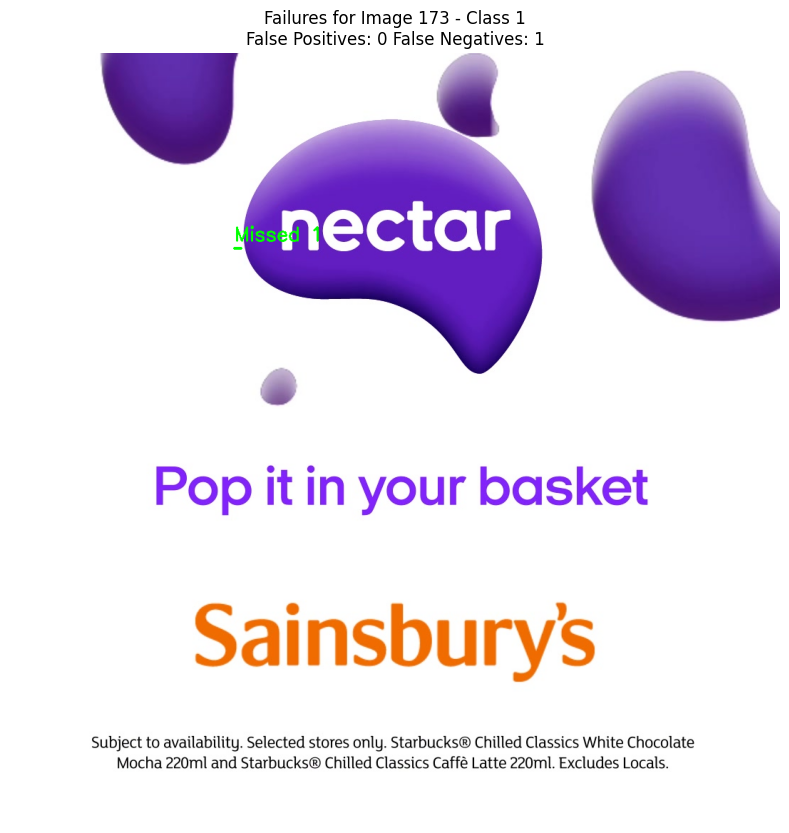

In [25]:
try:
    img_data, failure_data = next(failure_iter)
    print(f"Image ID: {img_data['id']}")
    # print(f"FP: {len(failure_data['false_positives'])}")
    # print(f"FN: {len(failure_data['false_negatives'])}")
    visualize_case(img_data, failure_data, class_id=1)
except StopIteration:
    print("DONE")

In [40]:
def visualize_detections(img_data, ground_truth, predictions):
    """
    Visualizes ground truth and predicted bounding boxes on an image
    """
    image = cv2.imread(img_data['file_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    
    # Plot ground truth boxes in green
    for bbox in ground_truth:  # bbox is already [x,y,w,h]
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, color='green', linewidth=2, label='Ground Truth')
        plt.gca().add_patch(rect)
    
    # Plot predicted boxes in red
    for bbox in predictions:  # bbox is already [x,y,w,h]
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2, label='Prediction')
        plt.gca().add_patch(rect)
    
    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.axis('off')
    plt.show()

In [62]:
def case_iterator(imgs, annotations, detector):
    """
    """
    img_ids = list(annotations.keys())
    
    while True:
        img_id = random.choice(img_ids)
        img_data = next(img for img in imgs if img['id'] == img_id)
        
        ground_truth = [ann['bbox'] for ann in annotations[img_id]]
        
        image = cv2.imread(img_data['file_name'])
        predictions = detector.detect_objects(image)

        print("Ground truth:", ground_truth)
        print("Predictions:", predictions)
        
        yield img_data, ground_truth, predictions

def visualize_case(img_data, ground_truth, predictions):
    """
    Visualize BBOX + IoU
    """
    image = cv2.imread(img_data['file_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(image)

    for bbox in ground_truth:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, color='green', linewidth=2, label='Ground Truth')
        plt.gca().add_patch(rect)

    if isinstance(predictions, dict):
        for class_id, boxes in predictions.items():
            for pred_bbox in boxes:

                best_iou = max(compute_iou(pred_bbox, gt_bbox) for gt_bbox in ground_truth)
                
                x, y, w, h = pred_bbox
                rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2, label='Pred')
                plt.gca().add_patch(rect)
                
                plt.plot([], [], ' ', label=f'IoU: {best_iou:.2f}')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.axis('off')
    plt.show()

2025-02-18 23:05:38,374 - INFO - Detected 1 at [739, 957, 129, 105]
2025-02-18 23:05:38,390 - INFO - Detected 2 at [888, 980, 176, 62]


Ground truth: [[893.4782608695652, 986.086956521739, 166.9565217391304, 53.47826086956519], [748.6956521739131, 962.6086956521738, 117.39130434782618, 100.43478260869573]]
Predictions: {1: [[739, 957, 129, 105]], 2: [[888, 980, 176, 62]]}


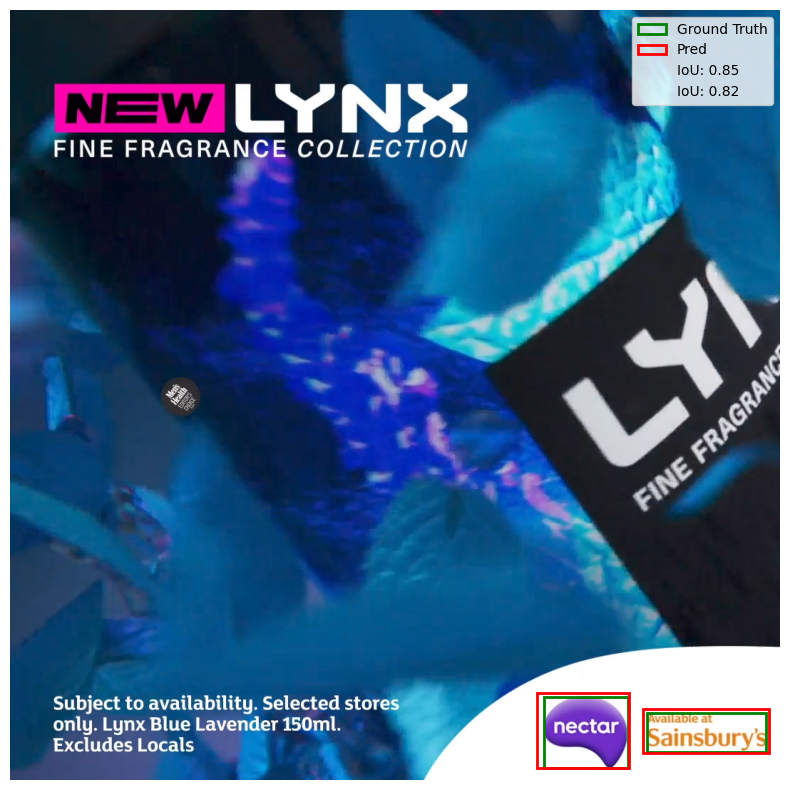

In [68]:
img_data, gt_boxes, pred_boxes = next(random_iter)
visualize_case(img_data, gt_boxes, pred_boxes)